# ASTR-589 HW2

We showed in the homework that the ionization fraction inside an HII region is given by the equation

$$
0 = \frac{(1-x)e^{-(1-x)n_H \sigma_0 r}}{x^2} \frac{2\pi^2 R^2 \sigma_0 k^3 T^3}{h^3 c^2 r^2 n_H \alpha(T)} \int_{u_0}^{\infty} \frac{u^2}{e^u - 1}~du -1
$$

We are given that $n_H = 10~\rm{cm}^{-3}$, $\sigma_0 = 6.3\times 10^{-18}~\rm{cm}^2$, and that $\alpha(T=10000\rm{K}) = 2.59\times10^{-13}~\rm{cm}^3~\rm{s}^{-1}$ inside the nebula.

We can rewrite this function as a second order polynomial.

$$
0 = (1-x)e^{-(1-x)n_H \sigma_0 r} \frac{2\pi^2 R^2 \sigma_0 k^3 T^3}{h^3 c^2 r^2 n_H \alpha(T)} \int_{u_0}^{\infty} \frac{u^2}{e^u - 1}~du - x^2
$$

We can then solve this function using polynomial root solving.

In [216]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve, bisect, brentq, brenth, ridder, newton, root
import astropy.units as u
from astropy.constants import c, h, k_B
import matplotlib.pyplot as plt

First, let us define the entire function as a product of three separate functions.

In [335]:
def unsolved(x, r, R, T, nH, s0, aT, l0):
    '''
    Function define the ionization fraction around a hot star in an HI region. Must be solved numerically.
    '''
    depend_val = depend(x, r, nH, s0)
    # BP Calculating all x-dependent terms.
    coeff_val = coeff(r, R, T, nH, s0, aT)
    # BP Calculating all constant coefficient terms.
    integ_val = integ(l0, T)
    # BP Numerically integrating the integrand.
    # print('x:', x)
    # print('val:', first * second * third - 1, '\n')
    return depend_val * coeff_val * integ_val - x**2

Next, lets define the first of the three functions

In [336]:
def depend(x, r, nH, s0):
    '''
    Function to define all x-dependent terms in the ionization fraction equation.
    '''
    expo = np.exp(-(1-x)*(nH * s0 * r).cgs)
    # BP Calculating exponential part.
    
    return ((1-x) * expo).cgs

In [337]:
def coeff(r, R, T, nH, s0, aT):
    '''
    Function to calculate the constant coefficient terms in the ionization fraction equation.
    '''
    numer = 2 * np.pi**2 * R**2 * s0 * k_B**3 * T**3
    # BP Calculating numerator.
    denom = h**3 * c**2 * r**2 * nH * aT
    # BP Calculating denominator.
    
    return (numer / denom).cgs

In [338]:
def integ(l0, T):
    '''
    Function to numerically integrate the integral in the ionization fraction equation.
    '''
    v0 = l0.to(u.Hz, equivalencies=u.spectral())
    # BP Converting the ionization wavelength into ionization frequency.
    u0 = h * v0 / (k_B * T)
    u0 = u0.cgs
    # BP Calculate the lower integration limit.
    
    def integrand(u):
    # BP Defining inner integrand to numerically solve.
        return u**2 / (np.exp(u) - 1)
    
    I, _ = quad(integrand, u0, u0*100)
    # BP Numerically integrate from u0 to infinity.
    
    return I

Now we need to actually solve the defined equation, which we can do by using a root solving tool.

In [339]:
def ion_frac(r, R, T, nH=10/(u.cm**3), s0=6.3e-18*u.cm**2, aT=2.59e-13*u.cm**3/u.s, l0=912*u.AA):
    '''
    Function to calculate the ionization fraction at a given radius from a hot ionizing star. Can be looped over a grid of radii.
    '''
    func = lambda x: unsolved(x, r, R, T, nH, s0, aT, l0).cgs
    # BP Defining function will all proper variables.
    
    upper = 1
    lower = 1e-5
    
    # if r>14.5*u.pc:
    #     start = 0
    # else:
    #     start = 1
    
    zero = fsolve(func, [0.99])
    # Solving for where the function equals 0.
    
    # print(func(lower), func(upper))
    # zero = root(func, 0.01, method='hybr', tol = 1e-10).x
    
    p = poly(x, r, R, T, nH, s0, aT, l0)
    zero = np.roots(p)
    
    return zero

We can now calculate the ionization fraction over the entire nebula.

## First Star
$T = 45000~\rm{K}$

$R = 11~R_\odot$

Text(0.5, 1.0, 'Ionization Fraction')

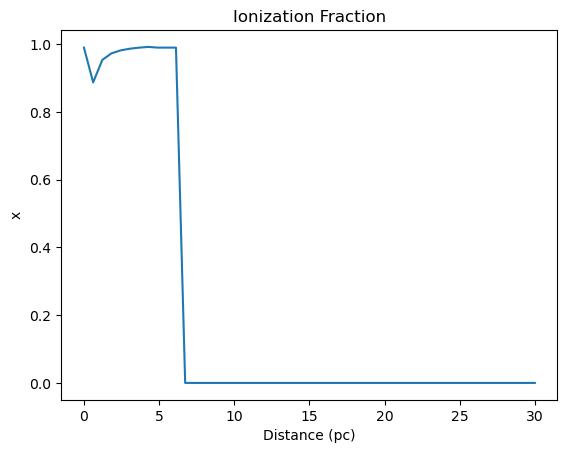

In [340]:
T = 45000*u.K
# BP Stellar temperature.
R = 11*u.R_sun
# BP Stellar radius.

rs = np.linspace(0, 30, 50)*u.pc
# BP Defining space to calculate ionization fraction in parsecs as Stromgren sphere is ~20 pc.

ionization = []
# BP Empty array to store ionizations.

for r in rs:
    ionization.append(ion_frac(r, R, T))

_ = plt.plot(rs, ionization)
plt.xlabel('Distance (pc)')
plt.ylabel('x')
plt.title('Ionization Fraction')

In [334]:
ionization

[array([0.99]),
 array([0.99999979]),
 array([0.99999914]),
 array([0.99999807]),
 array([0.99999657]),
 array([0.99]),
 array([0.98992134]),
 array([0.9920159]),
 array([0.99351617]),
 array([0.99463554]),
 array([0.9954977]),
 array([0.99617896]),
 array([0.99672877]),
 array([0.9971805]),
 array([0.99755742]),
 array([0.99787626]),
 array([0.99814934]),
 array([0.99838598]),
 array([0.99859341]),
 array([0.99877743]),
 array([0.99894288]),
 array([0.99909418]),
 array([0.99923605]),
 array([0.99937543]),
 array([0.99953358]),
 array([0.99968977]),
 array([0.99973964]),
 array([0.99978474]),
 array([0.99982616]),
 array([0.99986166]),
 array([0.99989474]),
 array([0.99992488]),
 array([0.99995225]),
 array([0.99997735]),
 array([1.00000011]),
 array([1.00002089]),
 array([1.00004001]),
 array([1.00005766]),
 array([1.00007308]),
 array([1.0000885]),
 array([1.00010166]),
 array([1.00011506]),
 array([1.00012674]),
 array([1.0001377]),
 array([1.00014727]),
 array([1.00015709]),
 arra

# Star 2

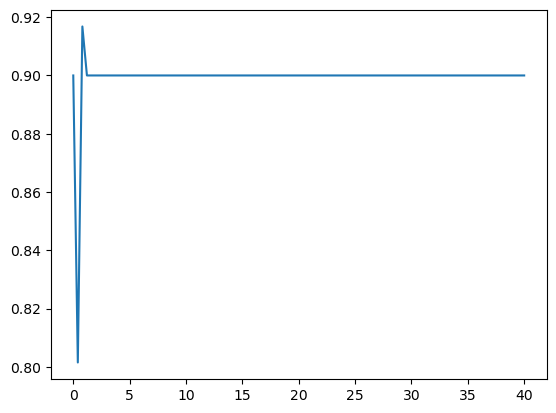

In [121]:
T = 40000*u.K
# BP Stellar temperature.
R = 20*u.R_sun
# BP Stellar radius.

rs = np.linspace(0, 40, 50)*u.pc
# BP Defining space to calculate ionization fraction in parsecs as Stromgren sphere is ~20 pc.

ionization = []
# BP Empty array to store ionizations.

for r in rs:
    ionization.append(ion_frac(r, R, T))
    
plt.plot(rs, ionization)

In [293]:
2900*0.00514*u.pc

<Quantity 14.906 pc>

In [294]:
3500*0.00514*u.pc

<Quantity 17.99 pc>

(-10.0, 0.0)

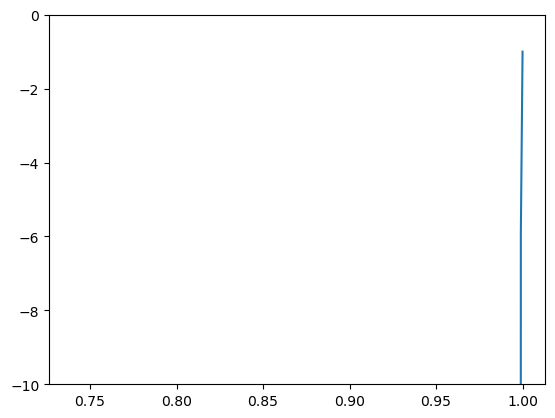

In [299]:
r = 14*u.pc
x = np.linspace(1e-2, 1, 1000)

test = unsolved(x, r, R, T, nH=10/(u.cm**3), s0=6.3e-18*u.cm**2, aT=2.59e-13*u.cm**3/u.s, l0=912*u.AA)
plt.plot(x, test)
plt.ylim(-10, 0)